# JBFG Data Analysis Competition

In [17]:

# #!pip install watermark
# %load_ext watermark
# %watermark -a 'DataLine' -nmv --packages numpy,pandas,sklearn,imblearn,tensorflow,plotly,matplotlib,seaborn,missingno,lightgbm


#### 컬럼 데이터 및 Null 건수 확인

## DNN
***

### Import Library

In [18]:
import pandas as pd
import numpy as np
from itertools import combinations
import time
import datetime
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

### Function Definition

#### encode_onehot()

In [19]:
# 원-핫 인코딩 처리 
# ----------------
def encode_onehot(df):
    '''
        데이터프레임의 object type 컬럼을 원-핫 인코딩하는 함수
        
        Args:
            df (df) : DataFrame
        Return:
            DataFrame
    '''
    catcols = df.select_dtypes(exclude = ['int64','float64']).columns
    df = pd.get_dummies(df, columns = catcols)
    
    return df

#### proc_split_smote()

In [20]:


def proc_split_smote(X_new, y):
    #Model Training
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE

    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, stratify=y, random_state=0)

    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train=sm.fit_resample(X_train,y_train)
    
    return X_train, y_train, X_test, y_test

In [21]:
#### proc_feature_split()

In [22]:
def proc_feature_split(X_new, y):
    #Model Training
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE

    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, stratify=y, random_state=0)

    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train=sm.fit_resample(X_train,y_train)
    
    return X_train, y_train, X_test, y_test

#### proc_standardization() - 표준화 함수

In [23]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

def proc_standardization(X_train, X_test, X_eval):
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    X_eval  = scaler.transform(X_eval)
    
    return X_train, X_test, X_eval

#### select_feature()

In [24]:
# 중요 Feature 식별
# ----------------
def select_feature(df, y_labels, chosen_model):

    np.random.seed(42)    
    
    available_models = {
    'ExtraTrees': ExtraTreesClassifier(n_estimators=700),
    'RandomForest': RandomForestClassifier(n_estimators=700),
    'LGBMC': LGBMClassifier(n_estimators=700, random_state=42, boosting_type='GOSS'),
    'LGBMR': LGBMRegressor(),
    'Xg Boost':XGBClassifier(booster='gbtree', importance_type='gain', eval_metric='auc'),
    }

    # Create the selected model
    clf = available_models[chosen_model]

    clf = clf.fit(df, y_labels)                                     # Train

    if chosen_model == 'LGBMC' or chosen_model == 'LGBMR': 
        feature_importances = clf.booster_.feature_importance(importance_type="gain")
    else:        
        feature_importances = clf.feature_importances_


    chosen_model = SelectFromModel(clf, prefit=True)
    X_df = chosen_model.transform(df.values) 
    selected_feature_indices = chosen_model.get_support(indices=True)

    selected_columns = df.columns[selected_feature_indices]         # Get the indices of the selected features
    
    return X_df, selected_columns

#### fit_predict_eval()

In [25]:

# 예측 및 평가
# -----------
def fit_predict_eval(models, model_comparison, X_train, y_train, X_test, y_test):
   
    # 초기화
    # ------
    best_roc_auc = 0
    
    # Define Models
    # ------------- 
    # No: 1 origin
    # models = [
    #     ('LogisticRegression', LogisticRegression()),
    #     ('DecisionTree', DecisionTreeClassifier(criterion='entropy', random_state=0)),
    #     ('ExtraTrees', ExtraTreesClassifier(n_estimators=700)),
    #     ('KNN', KNeighborsClassifier(n_neighbors=5)),
    #     ('NaiveBayes', GaussianNB()),
    #     ('RandomForest', RandomForestClassifier(n_estimators=700, criterion='entropy', random_state=0)),
    #     ('LightGBM', LGBMClassifier(n_estimators=700, random_state=42, boosting_type='GOSS')),
    #     ('XgBoost', XGBClassifier(n_estimators=700, random_state=42, eval_metric='auc')),
    # ]

    
    # Model Fit and Testing
    # ---------------------
    for model_name, classifier in models:
        start_time = time.time()


        # 학습
        # ----            
        classifier.fit(X_train, y_train)
        
        
        # 학습된 모델 저장하기 - 필요한 경우 향후 사용할 예정
        # -----------------------------------------------
        # file_name = f'./models/{model_name}.pkl'
        # joblib.dump(classifier, file_name)


        # 예측
        # ---- 
        y_pred = classifier.predict(X_test)


        # 평가
        # ---- 
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_class_0 = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
        accuracy_class_1 = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1], )

        precision = precision_score(y_test , y_pred)
        recall = recall_score(y_test , y_pred)
        f1 = f1_score(y_test, y_pred)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        auces = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=skf, scoring="roc_auc")
        cv_auc = auces.mean()
        cv_std = auces.std()
        
        pred_proba = classifier.predict_proba(X_test)[:, 1]        
        roc_auc = roc_auc_score(y_test, pred_proba)
        
        
        # 예측 평가 결과 저장
        # -----------------
        model_comparison[f'{model_name}'] = [accuracy, accuracy_class_0, accuracy_class_1, precision, recall, f1, cv_auc, cv_std, roc_auc]
        
        
        # Best ROC_AUC Value Return
        # -------------------------
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            
        
        # Print Log
        # ---------    
        cur_datetime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        end_time = time.time()
        delta_time = end_time - start_time
        print(f'Model Name: [{model_name:<18}], {cur_datetime}, {str(datetime.timedelta(seconds=delta_time)).split(".")[0]},  BEST AUC: {best_roc_auc:0.6f}, AUC: {roc_auc:0.6f}')


#### print_eval_result()

In [26]:
def print_eval_result(model_comparison):

    # # MODEL COMPARISSON
    # Model_com_df=pd.DataFrame(model_comparison).T
    # Model_com_df.columns=['Accuracy','Accuracy-0','Accuracy-1', 'Precision', 'Recall', 'F1-Score','CV AUC','CV std', 'AUC']
    # Model_com_df=Model_com_df.sort_values(by='AUC',ascending=False)
    # # display(Model_com_df.style.format("{:.2%}").background_gradient(cmap='magma'))

    Model_com_df = pd.DataFrame(model_comparison).T
    Model_com_df.columns = ['Accuracy', 'Accuracy-No', 'Accuracy-Yes', 'Precision', 'Recall', 'F1-Score', 'CV AUC', 'CV std', 'AUC']
    Model_com_df = Model_com_df.sort_values(by='AUC', ascending=False)

    def highlight_below_75(s):
        if s.name != 'CV std' and isinstance(s, pd.Series) and s.dtype == 'float64':
            return ['color: red' if value < 0.75 else 'color: black' for value in s]
        else:
            return ['color: black'] * len(s)

    # styled_df = Model_com_df.iloc[:10,:].style.highlight_max(axis=0).apply(highlight_below_75, subset=pd.IndexSlice[:, :'CV AUC']).format("{:.2%}", subset=pd.IndexSlice[:, :'CV AUC'])
    styled_df = Model_com_df.style.highlight_max(axis=0).apply(highlight_below_75, subset=pd.IndexSlice[:, :'CV AUC']).format("{:.2%}", subset=pd.IndexSlice[:, :'CV AUC'])
    display(styled_df)

#### data_transform()

In [27]:

def data_transform(df):

    # 데이터 변환
    # ------------------- 
    df = df.drop('cstno', axis=1)
    df = df.drop('sex', axis=1)
    df['imcome_cat']=df['imcome_cat'].replace({'Less than $40K':40000, '$40K - $60K':50000, '$60K - $80K':70000, '$80K - $120K':100000, '$120K +':120000, 'Unknown':63000})

   
    # 결측치 처리
    # ----------
    df = df.groupby(['marital_stat']).apply(lambda x: x.fillna(x.mean(numeric_only=True)))
    df = df.reset_index(drop=True)
    df.dropna(axis=0, inplace=True)


    # One-Hot Encoding
    # ----------------
    df = encode_onehot(df)     
    
    return df

#### test_transform()

In [28]:
def test_transform(source_df, eval_df):

    # 데이터 변환
    # -----------
    source_df = data_transform(source_df)
    eval_df = data_transform(eval_df)

        
    # 테스트 및 평가를 위한 데이터 분리
    # -------------------------------
    X_Features = source_df.drop(['is_churned'], axis=1)
    y_labels = source_df['is_churned']

    X_eval=eval_df.drop(['is_churned'], axis=1)
    y_eval=eval_df['is_churned'].values


    # 중요 Feature Column 선택
    # -----------------------
    X_Features_new, selected_columns = select_feature(X_Features, y_labels, 'RandomForest')
    X_eval = X_eval[selected_columns]


    # Train and Test 데이터 생성 및 가공
    # ---------------------------------
    X_train, y_train, X_test, y_test = proc_split_smote(X_Features_new, y_labels.values)
    

    # standardization ~ StandardScaler 적용
    # -----------------------------------
    X_train, X_test, X_eval = proc_standardization(X_train, X_test, X_eval.values) 
    
    return X_train, y_train, X_test, y_test, X_eval, y_eval 


### 학습 및 Test 평가

#### 데이터 로딩 및 초기화

In [29]:
# 경진대회를 위해 주최측에서 제공한 데이터(EDA 및 ML 학습을 위한 데이터)
bank_churner_df = pd.read_csv("./data/bank_churner.csv")


 # 평가를 위한 데이터 로드 - 평가자님 평가데이터 경로를 입력해 주세요!!! - 평가 결과는 평가결과 출력을 확인
eval_churner_df = pd.read_csv("./data/eval_churner.csv")

#### 초기화 및 전처리

In [30]:
# 전처리 
# -----
X_train, y_train, X_test, y_test, X_eval, y_eval = test_transform(bank_churner_df, eval_churner_df)

#### Model Define

* 모델 신경망 구조 정의

In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers

ccfd = models.Sequential()
ccfd.add(layers.Dense(128, activation = 'relu', input_shape = (13,)))
ccfd.add(layers.Dense(64, activation = 'relu'))
ccfd.add(layers.Dense(32, activation = 'relu'))
ccfd.add(layers.Dense(1, activation = 'sigmoid'))

* 모델 구조 확인

In [32]:
ccfd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1792      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


#### 3) Model Compile

In [50]:
ccfd.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['AUC'])

> ## 4) Model Fit

* 모델 학습 수행

In [51]:
%%time

Hist_ccfd = ccfd.fit(X_train, y_train,
                     epochs = 50,
                     batch_size = 1024,
                     validation_data = (X_test, y_test))

Epoch 1/50
10/10 [==============================] - 1s 21ms/step - loss: 0.0290 - auc: 0.9996 - val_loss: 0.5568 - val_auc: 0.8815
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.0218 - auc: 0.9998 - val_loss: 0.5482 - val_auc: 0.8756
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0206 - auc: 0.9998 - val_loss: 0.5415 - val_auc: 0.8798
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0184 - auc: 0.9999 - val_loss: 0.5535 - val_auc: 0.8771
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0181 - auc: 0.9999 - val_loss: 0.5525 - val_auc: 0.8823
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0175 - auc: 0.9999 - val_loss: 0.5557 - val_auc: 0.8762
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0175 - auc: 0.9999 - val_loss: 0.5711 - val_auc: 0.8803
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0175 - auc: 0.9

> ## 5) 학습 결과 시각화

* Loss Visualization

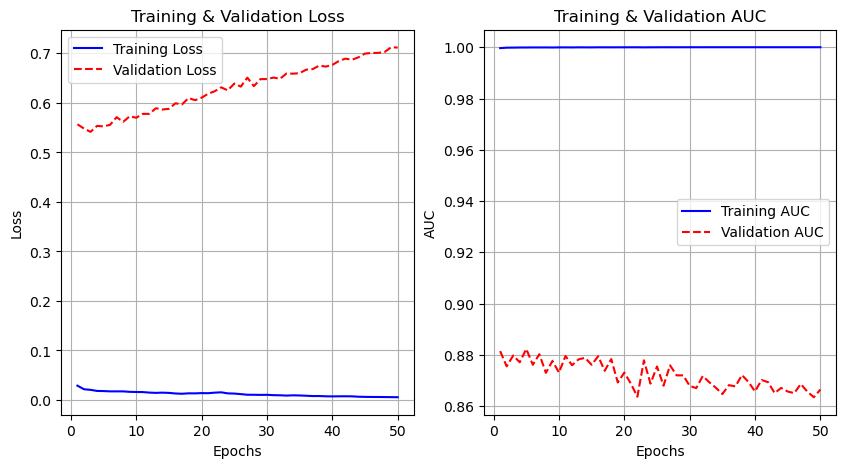

In [67]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_ccfd.history['loss']) + 1)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_ccfd.history['loss'], 'b-')
plt.plot(epochs, Hist_ccfd.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_ccfd.history['auc'], 'b-')
plt.plot(epochs, Hist_ccfd.history['val_auc'], 'r--')
plt.title('Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'])
plt.grid()

plt.show()


# plt.figure(figsize = (9, 6))
# plt.plot(epochs, Hist_ccfd.history['loss'])
# plt.plot(epochs, Hist_ccfd.history['val_loss'])
# plt.title('Training & Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(['Training Loss', 'Validation Loss'])
# plt.grid()
# plt.show()

* AUC Visualization

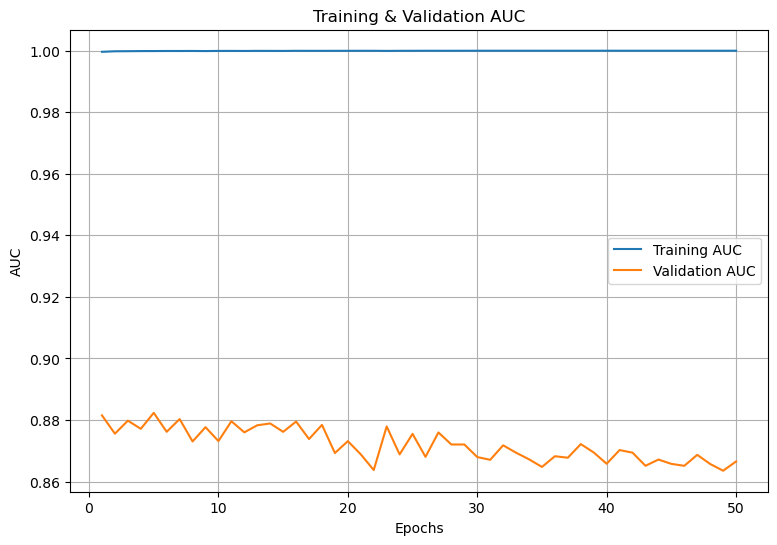

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_ccfd.history['auc']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_ccfd.history['auc'])
plt.plot(epochs, Hist_ccfd.history['val_auc'])
plt.title('Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'])
plt.grid()
plt.show()

> ## 6) Model Evaluate

* Loss & AUC

In [60]:
loss, auc = ccfd.evaluate(X_eval, y_eval)

print('Loss = {:.5f}'.format(loss))
print('AUC = {:.5f}'.format(auc))

64/64 [==============================] - 0s 934us/step - loss: 0.5222 - auc: 0.9315
Loss = 0.52219
AUC = 0.93145


> ## 7) Model Predict

In [61]:
import numpy as np

y_hat = np.round(ccfd.predict(X_eval))

y_hat

64/64 [==============================] - 0s 712us/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [62]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_eval, y_hat)

array([[1562,  137],
       [  50,  277]], dtype=int64)

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(y_eval, y_hat)}')
print(f'Precision: {precision_score(y_eval, y_hat, pos_label = 1)}')
print(f'Recall: {recall_score(y_eval, y_hat, pos_label = 1)}')

Accuracy: 0.9076999012833169
Precision: 0.6690821256038647
Recall: 0.8470948012232415
